In [1]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from skompiler import skompile

In [2]:
pd.set_option('display.max_columns', None)
warnings.simplefilter(action = 'ignore', category= Warning)

In [3]:
df = pd.read_csv('diabetes.csv')

In [4]:
y = df['Outcome']
X = df.drop(['Outcome'], axis = 1)

In [5]:
cart_model = DecisionTreeClassifier(random_state=1).fit(X,y)

In [6]:
y_pred = cart_model.predict(X)

In [7]:
y_prob = cart_model.predict_proba(X)[:, 1]

In [8]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       268

    accuracy                           1.00       768
   macro avg       1.00      1.00      1.00       768
weighted avg       1.00      1.00      1.00       768



In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=17)
cart_model = DecisionTreeClassifier(random_state = 17).fit(X_train, y_train)


In [10]:
y_pred = cart_model.predict(X_train)
y_prob = cart_model.predict_proba(X_train)[:, 1]
print(classification_report(y_train, y_pred))
roc_auc_score(y_train, y_prob)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       403
           1       1.00      1.00      1.00       211

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



1.0

In [11]:
y_pred = cart_model.predict(X_test)
y_prob = cart_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_prob)

              precision    recall  f1-score   support

           0       0.75      0.85      0.80        97
           1       0.67      0.53      0.59        57

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.72      0.73      0.72       154



0.6858383071079761

In [12]:
cross_val  = cross_validate(cart_model, X, y, cv = 10, scoring = ["accuracy","f1","roc_auc"])

In [13]:
print(cross_val['test_f1'].mean())
print(cross_val['test_accuracy'].mean())
print(cross_val['test_roc_auc'].mean())

0.5780669232692448
0.7148496240601504
0.6796239316239316


In [14]:
cart_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [15]:
cart_params = {'max_depth' : range(1,11),
               'min_samples_split': range(2,20)}


In [16]:
cart_best_grid = GridSearchCV(cart_model,
                                cart_params,
                                cv = 5,
                                scoring='f1',
                                n_jobs= -1,
                                verbose = 1).fit(X,y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits

In [17]:
cart_best_grid.best_params_

{'max_depth': 4, 'min_samples_split': 2}

In [18]:
cart_best_grid.best_score_

0.6395752751155839

In [19]:
cart_final = DecisionTreeClassifier(**cart_best_grid.best_params_, random_state=17).fit(X,y)
cart_final.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 17,
 'splitter': 'best'}

In [20]:
cart_final = cart_final.set_params(**cart_best_grid.best_params_).fit(X,y)

In [21]:
cv_results = cross_validate(cart_final, 
                            X, y,
                            cv = 5,
                            scoring=['accuracy','f1','roc_auc'])

In [22]:
cv_results['test_accuracy'].mean()

0.7305237246413717

In [23]:
cv_results['test_f1'].mean()

0.6395752751155839

In [24]:
cv_results['test_roc_auc'].mean()

0.7880422781271837

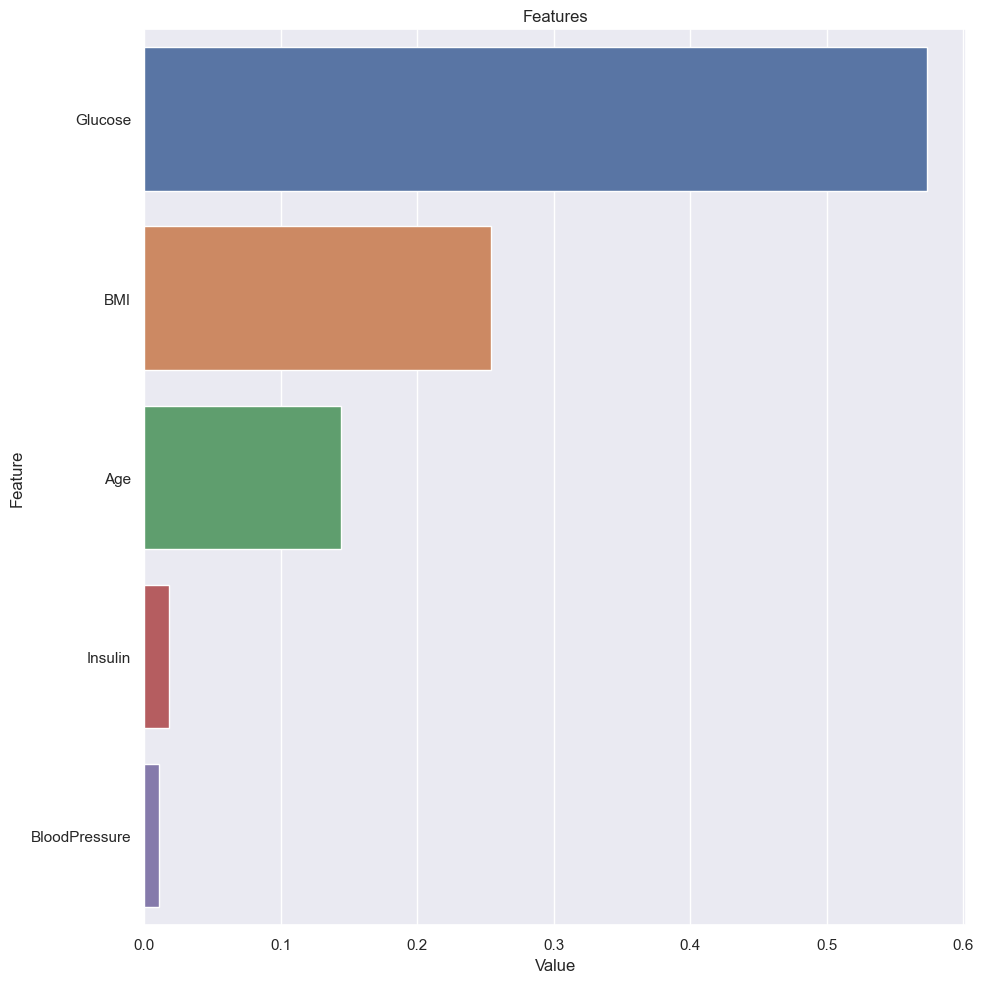

In [25]:
def plot_importance(model, features, num = len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1)
    sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value',
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
        
plot_importance(cart_final, X, num=5)        

In [26]:
#Analyzing Model Complexity with Learning Curves 

In [27]:
train_score, test_score = validation_curve(cart_final, X, y, 
                                           param_name='max_depth',
                                           param_range = range(1,11),
                                           scoring='roc_auc',
                                           cv = 10)

In [28]:
mean_train_score = train_score.mean(axis=1)

In [29]:
mean_test_score = test_score.mean(axis=1)

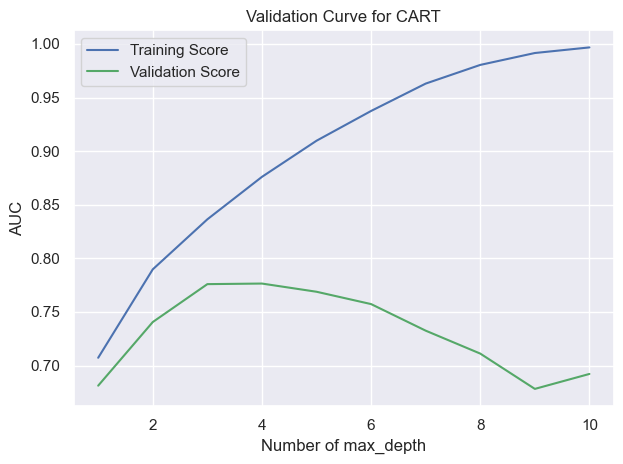

In [30]:
plt.plot(range(1,11), mean_train_score, label ='Training Score', color = 'b')
plt.plot(range(1, 11), mean_test_score, label='Validation Score', color = 'g')

plt.title('Validation Curve for CART')
plt.xlabel('Number of max_depth')
plt.ylabel('AUC')
plt.tight_layout()
plt.legend(loc='best')
plt.show()

In [31]:
def val_curve_params(model, X, y, param_name, param_range, scoring = 'roc_auc', cv=10):
    train_score, test_score = validation_curve(model, X, y, param_name= param_name, 
                                               param_range=param_range, scoring=scoring, cv=cv)
    mean_train_score = np.mean(train_score, axis=1)
    mean_test_score = np.mean(test_score, axis=1)
    
    plt.plot(param_range, mean_train_score, label='Training Score', color ='b')
    plt.plot(param_range, mean_test_score, label='Test Score', color = 'g')
    plt.title(f'Validation Curve for {type(model).__name__}')
    plt.xlabel(f'Number of {param_name}')
    plt.ylabel(f'{scoring}')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

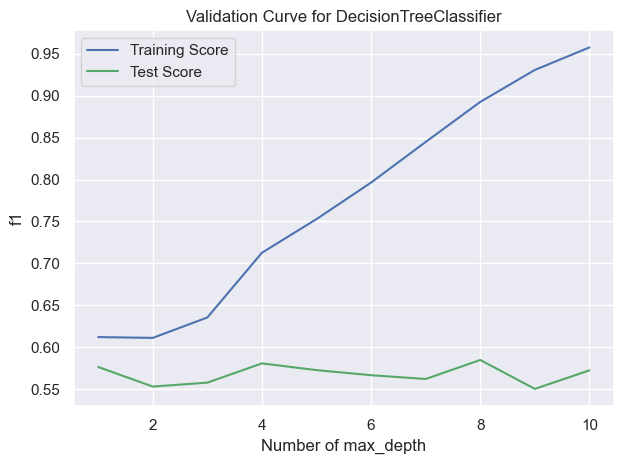

In [32]:
val_curve_params(cart_final, X, y, 'max_depth',range(1,11), scoring = 'f1')

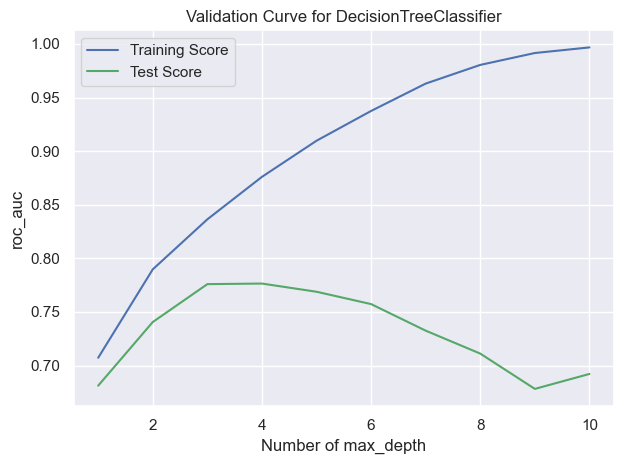

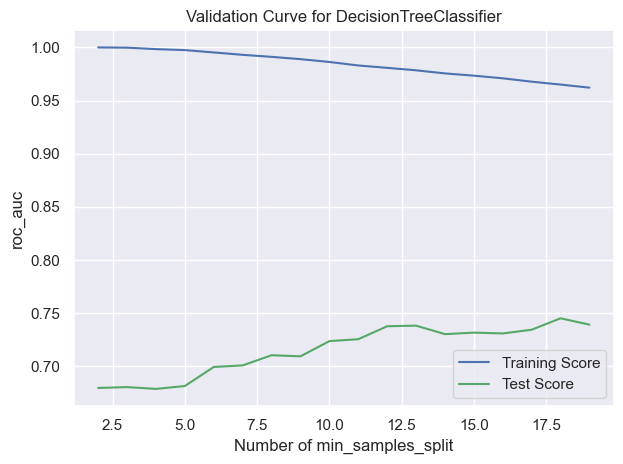

In [33]:
cart_val_params = [['max_depth', range(1,11)], ['min_samples_split',range(2,20)]]
for i in range(len(cart_val_params)):
    val_curve_params(cart_model, X, y, cart_val_params[i][0], cart_val_params[i][1])

In [34]:
def tree_graph(model, col_names, file_name):
    tree_str = export_graphviz(model, feature_names=col_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(file_name)

In [ ]:
tree_graph(model = cart_final, col_names = X.columns, file_name='cart_final.png')

In [36]:
tree_rules = export_text(cart_final, feature_names=list(X.columns))

In [37]:
print(tree_rules)

|--- Glucose <= 127.50
|   |--- Age <= 28.50
|   |   |--- BMI <= 45.40
|   |   |   |--- BMI <= 30.95
|   |   |   |   |--- class: 0
|   |   |   |--- BMI >  30.95
|   |   |   |   |--- class: 0
|   |   |--- BMI >  45.40
|   |   |   |--- BloodPressure <= 99.00
|   |   |   |   |--- class: 1
|   |   |   |--- BloodPressure >  99.00
|   |   |   |   |--- class: 0
|   |--- Age >  28.50
|   |   |--- BMI <= 26.35
|   |   |   |--- BMI <= 9.65
|   |   |   |   |--- class: 1
|   |   |   |--- BMI >  9.65
|   |   |   |   |--- class: 0
|   |   |--- BMI >  26.35
|   |   |   |--- Glucose <= 99.50
|   |   |   |   |--- class: 0
|   |   |   |--- Glucose >  99.50
|   |   |   |   |--- class: 0
|--- Glucose >  127.50
|   |--- BMI <= 29.95
|   |   |--- Glucose <= 145.50
|   |   |   |--- Insulin <= 132.50
|   |   |   |   |--- class: 0
|   |   |   |--- Insulin >  132.50
|   |   |   |   |--- class: 0
|   |   |--- Glucose >  145.50
|   |   |   |--- Age <= 25.50
|   |   |   |   |--- class: 0
|   |   |   |--- Age >  25

In [38]:
print(skompile(cart_final.predict).to('python/code'))

((((0 if x[5] <= 30.949999809265137 else 0) if x[5] <= 45.39999961853027 else
    1 if x[2] <= 99.0 else 0) if x[7] <= 28.5 else (1 if x[5] <= 
    9.649999618530273 else 0) if x[5] <= 26.350000381469727 else 0 if x[1] <=
    99.5 else 0) if x[1] <= 127.5 else ((0 if x[4] <= 132.5 else 0) if x[1] <=
    145.5 else 0 if x[7] <= 25.5 else 1) if x[5] <= 29.949999809265137 else
    (0 if x[7] <= 30.5 else 1) if x[1] <= 157.5 else 1 if x[4] <= 629.5 else 0)



In [45]:
print(skompile(cart_final.predict).to('excel'))

A1=IF((x2<=127.5),IF((x ...223 chars skipped... ((x5<=629.5),1,0))))


In [46]:
#Saving and Loading Model

In [47]:
joblib.dump(cart_final, 'cart_final.pkl')

['cart_final.pkl']

In [48]:
cart_model_from_disc = joblib.load('cart_final.pkl')

In [49]:
x = [12, 13, 20, 23, 4, 55, 12, 7]

In [50]:
cart_model_from_disc.predict(pd.DataFrame(x).T)

array([1], dtype=int64)